In [1]:
import os 
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

In [2]:
import torch
import matplotlib.pyplot as plt
import random
import gc

from sklearn.model_selection import train_test_split

# Own library imports
from vecopsciml.utils import TensOps
from vecopsciml.operators.zero_order import Mx, My
from vecopsciml.kernels.derivative import DerivativeKernels

# Function from this project
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results
from trainers.train import train_loop

# Import model
from architectures.pgnniv_baseline import PGNNIVBaseline

In [3]:
seed = 42
random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [4]:
# Create folders paths
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../../"))
DATA_PATH = os.path.join(ROOT_PATH, r'data/sigmoid_nonlinear_1000/sigmoid_nonlinear_1000.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/transfer_learning_1000')

PRETRAINED_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/non_linear_1000_0/baseline_model_10')
MODEL_RESULTS_TRANSFERLEARNING_PATH = os.path.join(ROOT_PATH, r'results/transfer_learning_1000/finetuning')

# Create folders (if necessary)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_TRANSFERLEARNING_PATH)

Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Embedding-Oriented-PGNNIV/results/transfer_learning_1000
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Embedding-Oriented-PGNNIV/results/transfer_learning_1000/finetuning


In [5]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Embedding-Oriented-PGNNIV/data/sigmoid_nonlinear_1000/sigmoid_nonlinear_1000.pkl


In [6]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cuda:0


### División de los datos

In [8]:
X_train = torch.Tensor(dataset['X_train']).unsqueeze(1)
y_train = torch.Tensor(dataset['y_train']).unsqueeze(1)
K_train = torch.tensor(dataset['k_train']).unsqueeze(1)
f_train = torch.tensor(dataset['f_train']).unsqueeze(1).to(torch.float32)

X_val = torch.Tensor(dataset['X_val']).unsqueeze(1)
y_val = TensOps(torch.Tensor(dataset['y_val']).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val']).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
f_val = TensOps(torch.tensor(dataset['f_val']).to(torch.float32).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

print("Train dataset length:", len(X_train))
print("Validation dataset length:", len(X_val))

Train dataset length: 800
Validation dataset length: 200


In [9]:
X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X_train, y_train, K_train, f_train, test_size=0.2, random_state=42)

X_train = X_train.to(DEVICE)
X_test = X_test.to(DEVICE)

y_train = TensOps(y_train.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
y_test = TensOps(y_test.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

K_train = TensOps(K_train.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
K_test = TensOps(K_test.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

f_train = TensOps(f_train.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
f_test = TensOps(f_test.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

In [10]:
# Other parameters
n_filters_explanatory = 5
n_modes = 10

# Predictive network architecture
input_shape = X_train[0].shape
predictive_layers = [20, 10, n_modes, 10, 20]
predictive_output = y_train.values[0].shape

# Explanatory network architecture
explanatory_input = Mx(My(y_train)).values[0].shape
explanatory_layers = [10]
explanatory_output = Mx(My(f_train)).values[0].shape

In [11]:
pretrained_pgnniv = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(pretrained_pgnniv.parameters(), lr=1e-4)
pretrained_pgnniv, optimizer, lists = load_results(pretrained_pgnniv, optimizer, PRETRAINED_RESULTS_PATH, map_location=torch.device('cpu'))

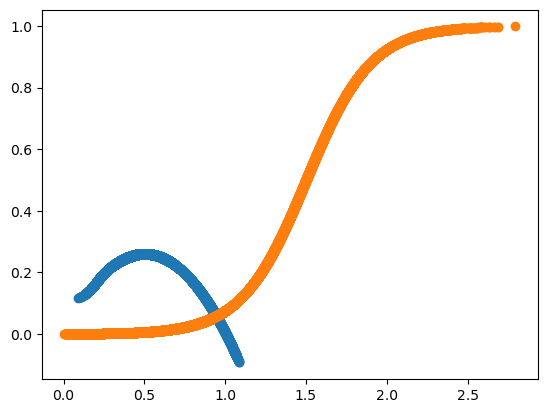

In [12]:
plt.scatter(Mx(My(TensOps(pretrained_pgnniv(X_train)[0], space_dimension=2, contravariance=0, covariance=0))).values.cpu().detach().numpy().flatten(), 
            pretrained_pgnniv(X_train)[1].cpu().detach().numpy().flatten())

plt.scatter(y_train.values.cpu().detach().numpy().flatten(), 
           K_train.values.cpu().detach().numpy().flatten())

In [13]:
pgnniv_pretrained_encoder = pretrained_pgnniv.encoder
pgnniv_pretrained_decoder = pretrained_pgnniv.decoder
pgnniv_pretrained_exp = pretrained_pgnniv.explanatory

for param in pgnniv_pretrained_encoder.parameters():
    param.requires_grad = True

for param in pgnniv_pretrained_decoder.parameters():
    param.requires_grad = True

for param in pgnniv_pretrained_exp.parameters():
    param.requires_grad = True

In [14]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [15]:
params_to_update = filter(lambda p: p.requires_grad, pretrained_pgnniv.parameters())
optimizer = torch.optim.Adam(params_to_update, lr=3e-4)

# Training parameters
start_epoch = 0
n_epochs = 1000

batch_size = 64
n_checkpoints = 5

train_loop(pretrained_pgnniv, optimizer, X_train, y_train, f_train, X_test, y_test, f_test,
           D, n_checkpoints, start_epoch=start_epoch, n_epochs=n_epochs, batch_size=batch_size, 
           model_results_path=MODEL_RESULTS_TRANSFERLEARNING_PATH, device=DEVICE)

Starting training from scratch.
Epoch 0, Train loss: 4.094e+08, Test loss: 4.201e+08, MSE(e): 4.089e+01, MSE(pi1): 2.640e+01, MSE(pi2): 1.746e+01, MSE(pi3): 2.147e+00
Epoch 10, Train loss: 2.353e+08, Test loss: 2.456e+08, MSE(e): 2.346e+01, MSE(pi1): 4.718e+01, MSE(pi2): 1.105e+01, MSE(pi3): 2.961e+00
Epoch 20, Train loss: 1.334e+08, Test loss: 1.405e+08, MSE(e): 1.323e+01, MSE(pi1): 6.604e+01, MSE(pi2): 7.249e+00, MSE(pi3): 3.715e+00
Epoch 30, Train loss: 8.404e+07, Test loss: 8.918e+07, MSE(e): 8.309e+00, MSE(pi1): 5.601e+01, MSE(pi2): 4.709e+00, MSE(pi3): 3.838e+00
Epoch 40, Train loss: 5.992e+07, Test loss: 6.405e+07, MSE(e): 5.906e+00, MSE(pi1): 4.585e+01, MSE(pi2): 3.591e+00, MSE(pi3): 4.017e+00
Epoch 50, Train loss: 4.755e+07, Test loss: 5.102e+07, MSE(e): 4.673e+00, MSE(pi1): 4.249e+01, MSE(pi2): 3.022e+00, MSE(pi3): 3.982e+00
Epoch 60, Train loss: 3.853e+07, Test loss: 4.156e+07, MSE(e): 3.774e+00, MSE(pi1): 3.944e+01, MSE(pi2): 2.585e+00, MSE(pi3): 3.877e+00
Epoch 70, Train l

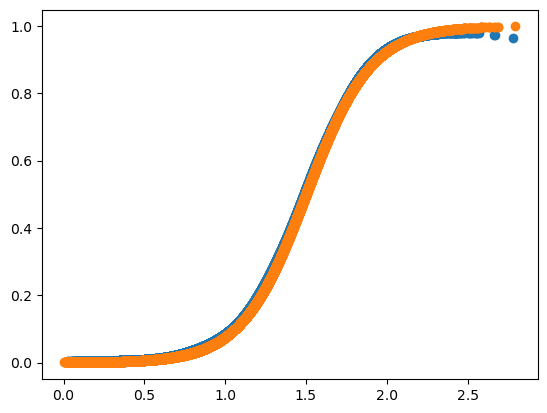

In [16]:
plt.scatter(Mx(My(TensOps(pretrained_pgnniv(X_train)[0], space_dimension=2, contravariance=0, covariance=0))).values.cpu().detach().numpy().flatten(), 
            pretrained_pgnniv(X_train)[1].cpu().detach().numpy().flatten())

plt.scatter(y_train.values.cpu().detach().numpy().flatten(), 
           K_train.values.cpu().detach().numpy().flatten())